SID: 44617585

# Assignment 2 - Classification of Business Reviews

**Submission deadline: Friday 26 April 2019, 11pm**

**Penalty for late submission: 4 marks per day**

**Assessment marks: 20 marks (20% of the total unit assessment)**

In this assignment you will design and evaluate several deep learning models that predict user ratings of restaurents given their reviews. **Note that, depending on the hardware of your machine, the running time of the training process may vary**. In particular:

* If your machine does not have a Graphics Processing Unit (GPU), every epoch may run for 30 seconds or longer. **For the exercise that uses LSTM, every epoch may run for 5 minutes or longer**.
* If your machine has a GPU and Keras is configured to use the GPU, every epoch may run for 5 to 10 seconds. **For the exercise that uses LSTM, every epoch may still run for 2 minutes or longer**.

**You are advised to start early and not to leave the exercises to the last minute since the total running time of the code may take over an hour**, and you may need to run parts of the code several times for testing and debugging.

The following code reads business reviews which are part of the [Yelp Dataset stored in Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset). The data are stored in a CSV file. The following code reads the CSV file and prints the contents of the first 5 records:

In [1]:
import pandas as pd
pd_data = pd.read_csv('yelp_review.zip')
pd_data[:5]

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


From the data, we will only use the reviews and the star rating. The following code extracts this information and places it in a list of pairs:

In [2]:
all_data = list(zip(pd_data['text'], pd_data['stars']))

In [3]:
len(all_data)

5261668

In [4]:
all_data[:5]

[("Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.",
  5),
 ("Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go. \n\nA bit outside of downtown montreal but take the metro out and it's less than a 10 minute walk from the station.",
  5),
 ("Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the insi

Let's now check the distribution of star ratings:

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
from collections import Counter
c = Counter([rating for text, rating in all_data])
c

Counter({5: 2253347, 4: 1223316, 3: 615481, 1: 731363, 2: 438161})

<BarContainer object of 5 artists>

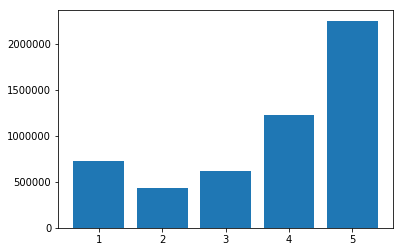

In [7]:
plt.bar(range(1,6), [c[1], c[2], c[3], c[4], c[5]])

The data set is fairly large with more than 5 million samples. To speed up the computations for this assigmnent, we will use 500,000 samples for training, 10,000 for the dev-test set and 10,000 for the test set. To reduce any possible bias while partitioning the data set, we will first shuffle the data and then partition into training data, dev-test data, and test data using the following code:


In [8]:
import random
random.seed(1234)
random.shuffle(all_data)
train_data, devtest_data, test_data = all_data[:500000], all_data[500000:510000], all_data[510000:520000]

The following code uses Keras' `Tokenizer` to convert the train, devtest, and test data into matrices of indices. We use only the 10,000 most frequent words of the training set. Note how we use the text of the training set to fit the tokenizer *before* attempting to tokenize any of the texts.

In [9]:
num_words = 10000 # Use this to inform the tokenizer what is the maximum number of words.

In [10]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts([d for d, l in train_data])

In [13]:
train_sequences = tokenizer.texts_to_sequences([d for d, l in train_data])

In [14]:
devtest_sequences = tokenizer.texts_to_sequences([d for d, l in devtest_data])

In [15]:
test_sequences = tokenizer.texts_to_sequences([d for d, l in test_data])

The following code plots a histogram with the lengths of all reviews.

(array([284620., 134588.,  47083.,  18197.,   7775.,   3619.,   1772.,
           961.,    575.,    810.]),
 array([1.0000e+00, 5.0550e+02, 1.0100e+03, 1.5145e+03, 2.0190e+03,
        2.5235e+03, 3.0280e+03, 3.5325e+03, 4.0370e+03, 4.5415e+03,
        5.0460e+03]),
 <a list of 10 Patch objects>)

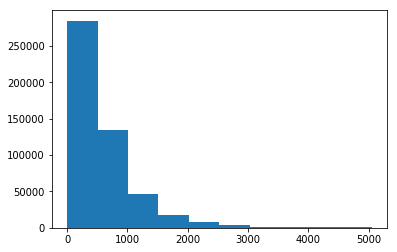

In [16]:
plt.hist([len(d) for d, l in train_data])

We can see that there are many fairly long reviews. To facilitate the assignment we will truncate the reviews using Keras' `pad_sequences`. The following code will select the last 100 words of each review:

In [17]:
train_vectors = pad_sequences(train_sequences, maxlen=100)

In [18]:
devtest_vectors = pad_sequences(devtest_sequences, maxlen=100)

In [19]:
test_vectors = pad_sequences(test_sequences, maxlen=100)

## Task 1 (1 mark)
Design a neural model that has the following sequence of layers:
* An embedding layer that generates embeddings with 50 dimensions.
* A layer that flattens the output of the previous layer.
* A dense layer with 50 nodes and a `relu` activation.

In [20]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(100, )))
model.add(layers.Embedding(num_words, 50))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                250050    
Total params: 750,050
Trainable params: 750,050
Non-trainable params: 0
_________________________________________________________________


## Task 2 (1 mark)
This is multi-class classification since we want to predict the review score. This means that the label needs to be converted into 5 outputs using one-hot encoding. Write Python code that converts the training, devtest, and test data to the appropriate encoding.

In [21]:
from keras.utils import to_categorical

# Write your code so that one_hot_train_labels has the one_hot encoding of the train labels
train_labels = [l-1 for d, l in train_data]

one_hot_train_labels = to_categorical(train_labels)
one_hot_train_labels[:10]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [22]:
# Write your code so that one_hot_devtest_labels has the one_hot encoding of the devtest labels
devtest_labels = [l-1 for d, l in devtest_data]

one_hot_devtest_labels = to_categorical(devtest_labels)
one_hot_devtest_labels[:10]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [23]:
# Write your code so that one_hot_test_labels has the one_hot encoding of the test labels
test_labels = [l-1 for d, l in test_data]

one_hot_test_labels = to_categorical(test_labels)
one_hot_test_labels[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Task 3 (1 mark)
Complete the design of the model by providing the correct output layer for this task. Compile the model by providing the appropriate loss function and the `accuracy` evaluation metric. Use `rmsprop` as the optimizer.

In [24]:
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                250050    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 750,305
Trainable params: 750,305
Non-trainable params: 0
_________________________________________________________________


## Task 4 (1 mark)
Train the model using 20 epochs and batch size of 512. Use the devtest set to determine the accuracy at each epoch.

In [25]:
history1_e20 = model.fit(train_vectors, one_hot_train_labels,
            epochs=20,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Instructions for updating:
Use tf.cast instead.
Train on 500000 samples, validate on 10000 samples
Epoch 1/20
500000/500000 [==============================] - 13s 26us/step - loss: 0.8552 - acc: 0.6364 - val_loss: 0.8032 - val_acc: 0.6517
Epoch 2/20
500000/500000 [==============================] - 12s 25us/step - loss: 0.7637 - acc: 0.6772 - val_loss: 0.8078 - val_acc: 0.6543
Epoch 3/20
500000/500000 [==============================] - 12s 25us/step - loss: 0.7061 - acc: 0.7072 - val_loss: 0.8403 - val_acc: 0.6429
Epoch 4/20
500000/500000 [==============================] - 13s 26us/step - loss: 0.6387 - acc: 0.7427 - val_loss: 0.8835 - val_acc: 0.6337
Epoch 5/20
500000/500000 [==============================] - 12s 25us/step - loss: 0.5741 - acc: 0.7734 - val_loss: 0.9598 - val_acc: 0.6209
Epoch 6/20
500000/500000 [==============================] - 12s 25us/step - loss: 0.5163 - acc: 0.7999 - val_loss: 1.0444 - val_acc: 0.6091
Epoch 7/20
500000/500000 [==============================] - 1

## Task 5 (1 mark)
Given the results that you observed in the previous question, train the model again, now using a better choice of number of epochs.

In [54]:
#As the accruacy dips early on there is no need to run as many Epochs so it has been reduced to 10.

history1_e10 = model.fit(train_vectors, one_hot_train_labels,
            epochs=10,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/10
500000/500000 [==============================] - 14s 28us/step - loss: 0.8575 - acc: 0.6358 - val_loss: 0.8045 - val_acc: 0.6522
Epoch 2/10
500000/500000 [==============================] - 13s 26us/step - loss: 0.7644 - acc: 0.6768 - val_loss: 0.8007 - val_acc: 0.6556
Epoch 3/10
500000/500000 [==============================] - 13s 25us/step - loss: 0.7090 - acc: 0.7046 - val_loss: 0.8238 - val_acc: 0.6488
Epoch 4/10
500000/500000 [==============================] - 13s 25us/step - loss: 0.6424 - acc: 0.7396 - val_loss: 0.8800 - val_acc: 0.6350
Epoch 5/10
500000/500000 [==============================] - 13s 25us/step - loss: 0.5771 - acc: 0.7702 - val_loss: 0.9421 - val_acc: 0.6272
Epoch 6/10
500000/500000 [==============================] - 12s 25us/step - loss: 0.5178 - acc: 0.7986 - val_loss: 1.0307 - val_acc: 0.6160
Epoch 7/10
500000/500000 [==============================] - 13s 25us/step - loss: 0.4651 - acc: 0.8218 - val_

## Task 6 (1 mark)
Given the results you obtained, comment whether there was overfitting. Explain your conclusions.

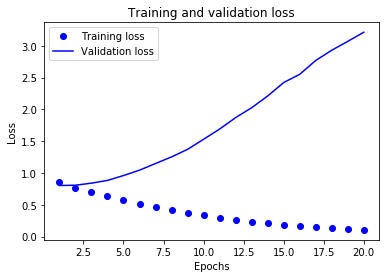

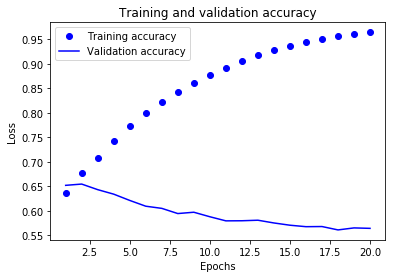

In [26]:
plt.clf()   # clear figure

loss = history1_e20.history['loss']
val_loss = history1_e20.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc = history1_e20.history['acc']
val_acc = history1_e20.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



Looking at the plotted data you can see that it overfits quickly.
After the second epoch you can see that the validation accuracy experiences a large dip and steadily decreases over the epochs as the test increases

## Task 7 (3 marks)
Now, use the average of embeddings instead of the `Flat` layer. You can do this by replacing the `Flat` layer with `GlobalAveragePooling1D`. Answer the following questions.
1. How many epochs do you need to train the network? Explain how you decided the number of epochs.
2. Is there overfitting? Explain why.
3. Are the results better or worse?

In [25]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(100, )))
model2.add(layers.Embedding(num_words, 50))
model2.add(layers.GlobalAveragePooling1D())
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(5, activation='softmax'))

model2.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [26]:
history2 = model2.fit(train_vectors, one_hot_train_labels,
            epochs=20,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Instructions for updating:
Use tf.cast instead.
Train on 500000 samples, validate on 10000 samples
Epoch 1/20
500000/500000 [==============================] - 11s 22us/step - loss: 0.9520 - acc: 0.5996 - val_loss: 0.8256 - val_acc: 0.6419
Epoch 2/20
500000/500000 [==============================] - 10s 21us/step - loss: 0.8035 - acc: 0.6579 - val_loss: 0.8091 - val_acc: 0.6497
Epoch 3/20
500000/500000 [==============================] - 10s 21us/step - loss: 0.7894 - acc: 0.6638 - val_loss: 0.8046 - val_acc: 0.6569
Epoch 4/20
500000/500000 [==============================] - 10s 21us/step - loss: 0.7820 - acc: 0.6675 - val_loss: 0.8017 - val_acc: 0.6592
Epoch 5/20
500000/500000 [==============================] - 10s 21us/step - loss: 0.7758 - acc: 0.6710 - val_loss: 0.8020 - val_acc: 0.6573
Epoch 6/20
500000/500000 [==============================] - 10s 21us/step - loss: 0.7705 - acc: 0.6737 - val_loss: 0.8047 - val_acc: 0.6584
Epoch 7/20
500000/500000 [==============================] - 1

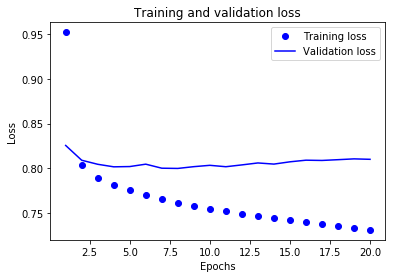

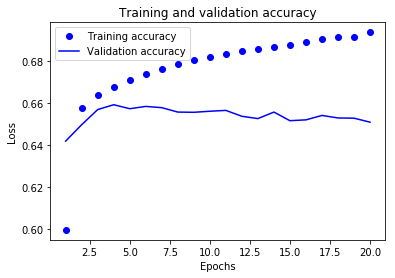

In [52]:
plt.clf()   # clear figure

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(loss2) + 1)

plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

plt.plot(epochs2, acc2, 'bo', label='Training accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1. How many epochs do you need to train the network? Explain how you decided the number of epochs.

    I experimented with numerous amounts of epochs starting from 50 however, 20 proved to be an optimal amount as
    it gave enough time to show progression through the accuracy and loss. It also made it clear to see the shape of 
    the different elements.


2. Is there overfitting? Explain why.

    Looking at the Training and Validation accuracy plot you can see that there is a slight amount of overfitting which can be 
    seen around epoch 14. Overfitting can be caused by too many epochs or by having a large variance in the dataset.
    
    
    
3. Are the results better or worse?

    Through viewing the plotted data I would say it is much clearer and provides a more optimum curve. We are also experiencing
    much less loss throughout training the data compared to when we used the Flat layer.

## Task 8 (3 marks)
Instead of averaging the word embeddings, now introduce a recurrent layer with LSTM cells. Conduct an analysis of the results similar to the one in the previous task. Feel free to add additional comments to your analysis.

In [39]:
model3 = models.Sequential()
model3.add(layers.InputLayer(input_shape=(100, )))
model3.add(layers.Embedding(num_words, 50))
model3.add(layers.LSTM(50))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(5, activation='softmax'))

model3.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 255       
Total params: 523,005
Trainable params: 523,005
Non-trainable params: 0
_________________________________________________________________


In [41]:
history3 = model3.fit(train_vectors, one_hot_train_labels,
            epochs=20,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/20
500000/500000 [==============================] - 133s 266us/step - loss: 0.7512 - acc: 0.6805 - val_loss: 0.7882 - val_acc: 0.6624
Epoch 2/20
500000/500000 [==============================] - 133s 266us/step - loss: 0.7298 - acc: 0.6888 - val_loss: 0.7723 - val_acc: 0.6658
Epoch 3/20
500000/500000 [==============================] - 133s 265us/step - loss: 0.7133 - acc: 0.6965 - val_loss: 0.7675 - val_acc: 0.6667
Epoch 4/20
500000/500000 [==============================] - 133s 266us/step - loss: 0.6987 - acc: 0.7034 - val_loss: 0.7604 - val_acc: 0.6727
Epoch 5/20
500000/500000 [==============================] - 134s 268us/step - loss: 0.6854 - acc: 0.7092 - val_loss: 0.7627 - val_acc: 0.6726
Epoch 6/20
500000/500000 [==============================] - 134s 268us/step - loss: 0.6736 - acc: 0.7150 - val_loss: 0.7584 - val_acc: 0.6743
Epoch 7/20
500000/500000 [==============================] - 133s 267us/step - loss: 0.6623 - acc:

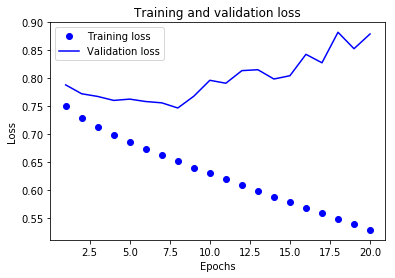

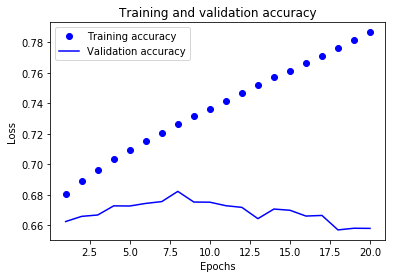

In [51]:
plt.clf()   # clear figure

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs3 = range(1, len(loss3) + 1)

plt.plot(epochs3, loss3, 'bo', label='Training loss')
plt.plot(epochs3, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

plt.plot(epochs3, acc3, 'bo', label='Training accuracy')
plt.plot(epochs3, val_acc3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

An LSTM layer of 50 cells was added and run over 50 epochs. as you can see by the results the validation accuracy got to a low of 0.6569 and a high of 0.6822 with the training accuracy consistently increasing.

using an LSTM layer helped fine tune the results compared to the other techniques used previously. the negative of course is the time consumption as a result of the extra work

## Task 9 (8 marks)
This final task is open-ended. Try to improve the system, and write below the code of your experiments and your results. Explain what you do to try to improve the results, what worked and what did not work.

Some strategies that may work:
* Change the number of hidden cells, change the number of hidden layers.
* Change the number of words per sentence. Currently it's 100 (but note that this will make the system slower).
* Use different features. For example you could try with tf.idf.
* Use pre-trained word embeddings.

For this exercise, it is important that you document what you are doing and explain your reasoning. We will value a good explanation, good error analysis and good motivation. You may obtain top marks even if your system did not do well, provided that your report in this section is sound. But you may obtain low marks in this exercise if the system does well but the report is of poor quality.

The rubric for assessing this exercise is as follows:
* Correct code (3 marks).
* Sound methodology and evaluation (3 marks).
* Sound explanations (2 marks).

Test 1:
* Number of words per sentence increased to 150
* Additional layer with activation 'relu' implemented with an input of 25, which was half of the above 'relu' layer

Test 1: Reasoning

By increasing the number of words per sentence I am hoping that this will allow the system to hopefully give a more detailed analysis of the data set.
And by adding another Dense layer of relu activation I am hoping that this creates a more accurate result. I chose relu as the activation as it relatively cheap to compute and it also converges data faster which will hopefully allow me to conduct more tests

In [46]:
train_vectors150 = pad_sequences(train_sequences, maxlen=150)
devtest_vectors150 = pad_sequences(devtest_sequences, maxlen=150)
test_vectors150 = pad_sequences(test_sequences, maxlen=150)

In [47]:
model4 = models.Sequential()
model4.add(layers.InputLayer(input_shape=(150, )))
model4.add(layers.Embedding(num_words, 50))
model4.add(layers.LSTM(50))
model4.add(layers.Dense(50, activation='relu'))
model4.add(layers.Dense(25, activation='relu'))
model4.add(layers.Dense(5, activation='softmax'))

model4.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 130       
Total params: 524,155
Trainable params: 524,155
Non-trainable params: 0
_________________________________________________________________


In [48]:
history4 = model4.fit(train_vectors150, one_hot_train_labels,
            epochs=20,
            batch_size=512,
            validation_data = (devtest_vectors150, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/20
500000/500000 [==============================] - 201s 401us/step - loss: 0.9218 - acc: 0.6055 - val_loss: 0.7980 - val_acc: 0.6602
Epoch 2/20
500000/500000 [==============================] - 198s 395us/step - loss: 0.7901 - acc: 0.6625 - val_loss: 0.7812 - val_acc: 0.6650
Epoch 3/20
500000/500000 [==============================] - 197s 395us/step - loss: 0.7571 - acc: 0.6769 - val_loss: 0.7804 - val_acc: 0.6662
Epoch 4/20
500000/500000 [==============================] - 197s 394us/step - loss: 0.7305 - acc: 0.6883 - val_loss: 0.7528 - val_acc: 0.6750
Epoch 5/20
500000/500000 [==============================] - 199s 397us/step - loss: 0.7101 - acc: 0.6966 - val_loss: 0.7325 - val_acc: 0.6849
Epoch 6/20
500000/500000 [==============================] - 199s 397us/step - loss: 0.6943 - acc: 0.7037 - val_loss: 0.7527 - val_acc: 0.6740
Epoch 7/20
500000/500000 [==============================] - 200s 400us/step - loss: 0.6804 - acc:

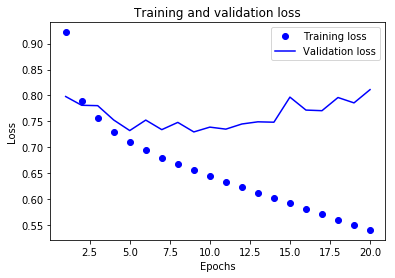

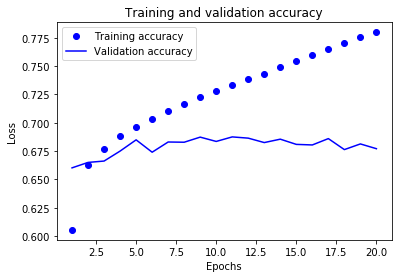

In [50]:
plt.clf()   # clear figure

loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs4 = range(1, len(loss4) + 1)

plt.plot(epochs4, loss4, 'bo', label='Training loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc4 = history4.history['acc']
val_acc4 = history4.history['val_acc']

plt.plot(epochs4, acc4, 'bo', label='Training accuracy')
plt.plot(epochs4, val_acc4, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test 1: Results
There is some slight overfitting with the results however the accruacy seems to be quite steady. The highest accuracy obtained was 0.6875 which still leaves room for improvement. I am hoping to conduct a more indepth version of this later on in the report.

Test 2:
* Complete restructure including Droput layers in an attempt to decrease overfitting
* LSTM removed
* Dense layer added
* increase epochs

Test 2: Reasoning

This test is more of an attempt at something new. It is going back to the earlier questions on the assigment by not using LSTM but the main rationale for this attempt is to see the effect of Dropout Layers. Dropout Layers are useful for optimizing and trying to reduce overfitting in a trained model by dropping random units to decrease variance and by giving the model less points to connection.
Using Dropout layers also increases the speed of training the model as it eliminates a large amount of the data throughout hence why the epochs have been increased to 50 to show a larger spread.

In [99]:
model5 = models.Sequential()
model5.add(layers.Dropout(0.2, input_shape=(100,)))
model5.add(layers.Dense(50, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(25, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(5, activation='softmax'))

model5.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_44 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_45 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_46 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 130       
Total params: 6,455
Trainable params: 6,455
Non-trainable params: 0
_________________________________________________________________


In [103]:
history5 = model5.fit(train_vectors, one_hot_train_labels,
            epochs=50,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/50
500000/500000 [==============================] - 4s 8us/step - loss: 9.2098 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 2/50
500000/500000 [==============================] - 4s 7us/step - loss: 9.2095 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 3/50
500000/500000 [==============================] - 3s 7us/step - loss: 9.2101 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 4/50
500000/500000 [==============================] - 3s 7us/step - loss: 9.2100 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 5/50
500000/500000 [==============================] - 4s 7us/step - loss: 9.2102 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 6/50
500000/500000 [==============================] - 3s 7us/step - loss: 9.2104 - acc: 0.4284 - val_loss: 9.2261 - val_acc: 0.4275
Epoch 7/50
500000/500000 [==============================] - 3s 7us/step - loss: 9.2098 - acc: 0.4284 - val_loss: 9.2261 -

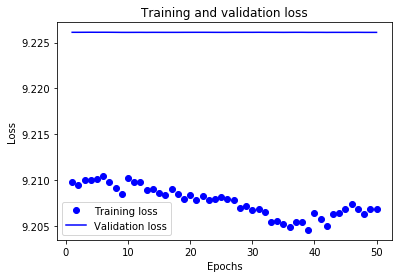

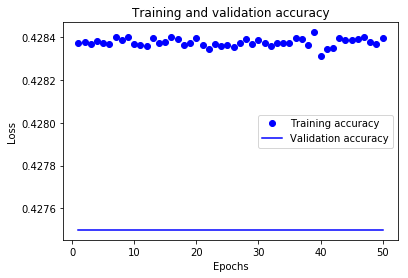

In [104]:
plt.clf()   # clear figure

loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs5 = range(1, len(loss5) + 1)

plt.plot(epochs5, loss5, 'bo', label='Training loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc5 = history5.history['acc']
val_acc5 = history5.history['val_acc']

plt.plot(epochs5, acc5, 'bo', label='Training accuracy')
plt.plot(epochs5, val_acc5, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test 2: Result
As expected the data wasnt optimal in terms of accuracy but it is interesting to see how the data turned out. The validation data was stagnate the entire time and the accraucy peaked at 0.4275 which is far from ideal.
This test wasnt entirely helpful but it was interesting to see a different method in model training

Test 3: 
* Number of words increased to 200
* input shape increased to 200
* Embedding layer increased to 100
* LSTM cell increased to 100
* multiple Dense layers with activation 'relu' added
* epochs dropped to 5 due to time requirements

Test 3: Reasoning

This test is to try have a glimpse at a truely indepth method of training. By increased the number of words and cells that this will be searching allows it to have a much more detailed look at the data. I'm hoping to see a slightly different result to what i've experienced previously.
Unfortunately time is not in my favour so I've had to drop down the epochs so that I have a chance to preview other testing methods. 


In [105]:
train_vectors200 = pad_sequences(train_sequences, maxlen=200)
devtest_vectors200 = pad_sequences(devtest_sequences, maxlen=200)
test_vectors200 = pad_sequences(test_sequences, maxlen=200)

In [108]:
model6 = models.Sequential()
model6.add(layers.InputLayer(input_shape=(200, )))
model6.add(layers.Embedding(num_words, 100))
model6.add(layers.LSTM(100))
model6.add(layers.Dense(50, activation='relu'))
model6.add(layers.Dense(25, activation='relu'))
model6.add(layers.Dense(10, activation='relu'))
model6.add(layers.Dense(5, activation='softmax'))

model6.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_55 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_56 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_57 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 55        
Total params: 1,087,040
Trainable params: 1,087,040
Non-trainable params: 0
_________________________________________________________________


In [110]:
history6 = model6.fit(train_vectors200, one_hot_train_labels,
            epochs=5,
            batch_size=512,
            validation_data = (devtest_vectors200, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/5
500000/500000 [==============================] - 530s 1ms/step - loss: 0.9068 - acc: 0.6130 - val_loss: 0.7948 - val_acc: 0.6643
Epoch 2/5
500000/500000 [==============================] - 543s 1ms/step - loss: 0.7660 - acc: 0.6725 - val_loss: 0.7524 - val_acc: 0.6722
Epoch 3/5
500000/500000 [==============================] - 545s 1ms/step - loss: 0.7201 - acc: 0.6921 - val_loss: 0.7491 - val_acc: 0.6819
Epoch 4/5
500000/500000 [==============================] - 535s 1ms/step - loss: 0.6931 - acc: 0.7044 - val_loss: 0.7184 - val_acc: 0.6933
Epoch 5/5
500000/500000 [==============================] - 526s 1ms/step - loss: 0.6711 - acc: 0.7145 - val_loss: 0.7055 - val_acc: 0.7004


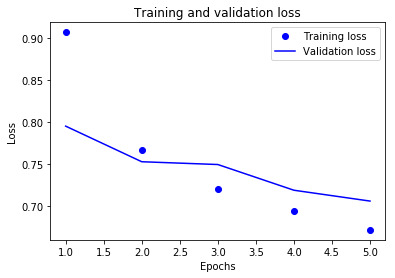

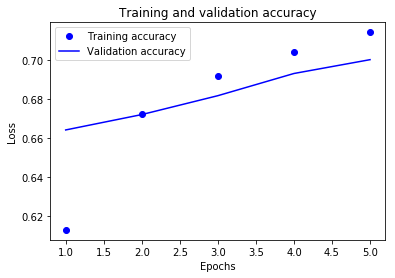

In [111]:
plt.clf()   # clear figure

loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']

epochs6 = range(1, len(loss6) + 1)

plt.plot(epochs6, loss6, 'bo', label='Training loss')
plt.plot(epochs6, val_loss6, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc6 = history6.history['acc']
val_acc6 = history6.history['val_acc']

plt.plot(epochs6, acc6, 'bo', label='Training accuracy')
plt.plot(epochs6, val_acc6, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test 3: Result
    
Looking at the results it is clear to say that it yields a higher accuracy than previous tests. With running only 5 epochs I was able to achieve 0.7004 and with more epochs It may be able to provide an even higher accuracy. As my last test I will re run this with a greater amount of epochs
    

Test 4:
* Multiple LSTM layers with cells 100, 50, 25 respectively
* reduce epoch count

Test 4: Reasoning

This test using a stacked LSTM method in an attempt of making the model capable of training a higher level representation.
By using a stacked LSTM technique I am hoping to increase the training depth which in turn allows myself to experience a 'deep learning technique' and also to observe what recurrent neural networks are capable of. 
At this point im not entirely sure how the results will pan out but I'm hoping to see some difference in comparison to other techniques.

Unfortunately once again I reduced the epoch count so that I would be able to view this test without being infringed completely 
    

In [112]:
model7 = models.Sequential()
model7.add(layers.InputLayer(input_shape=(100, )))
model7.add(layers.Embedding(num_words, 50))
model7.add(layers.LSTM(100, return_sequences=True))
model7.add(layers.LSTM(50, return_sequences=True))
model7.add(layers.LSTM(25))
model7.add(layers.Dense(50, activation='relu'))
model7.add(layers.Dense(5, activation='softmax'))

model7.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
lstm_22 (LSTM)               (None, 100, 100)          60400     
_________________________________________________________________
lstm_23 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
lstm_24 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dense_59 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 255       
Total params: 599,755
Trainable params: 599,755
Non-trainable params: 0
_________________________________________________________________


In [114]:
history7 = model7.fit(train_vectors, one_hot_train_labels,
            epochs=5,
            batch_size=512,
            validation_data = (devtest_vectors, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/5
500000/500000 [==============================] - 469s 938us/step - loss: 0.9205 - acc: 0.6060 - val_loss: 0.8514 - val_acc: 0.6328
Epoch 2/5
500000/500000 [==============================] - 451s 901us/step - loss: 0.7993 - acc: 0.6586 - val_loss: 0.7929 - val_acc: 0.6582
Epoch 3/5
500000/500000 [==============================] - 447s 894us/step - loss: 0.7588 - acc: 0.6758 - val_loss: 0.7600 - val_acc: 0.6692
Epoch 4/5
500000/500000 [==============================] - 450s 899us/step - loss: 0.7340 - acc: 0.6874 - val_loss: 0.7492 - val_acc: 0.6784
Epoch 5/5
500000/500000 [==============================] - 460s 919us/step - loss: 0.7155 - acc: 0.6959 - val_loss: 0.7455 - val_acc: 0.6825


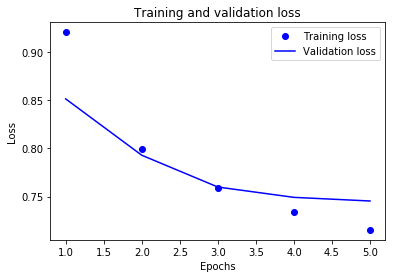

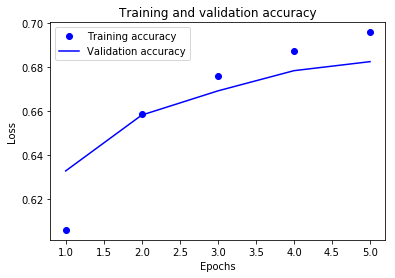

In [115]:
plt.clf()   # clear figure

loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']

epochs7 = range(1, len(loss7) + 1)

plt.plot(epochs7, loss7, 'bo', label='Training loss')
plt.plot(epochs7, val_loss7, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc7 = history7.history['acc']
val_acc7 = history7.history['val_acc']

plt.plot(epochs7, acc7, 'bo', label='Training accuracy')
plt.plot(epochs7, val_acc7, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test 4: Result

This test yielded an interesting result which I wish could be tested more. By upping the Epoch number to perhaps 20 would let us be able to see how the deep neural network operates at a more critical level. This iteration which had an epoch count of 5 gave us a top accuracy result of 0.6825 which is a competitive result to the other tests.

The plots shows us that it faced logarithmic growth by having a high increase initially which start to slow down over the iterations.

Test 5:
* Same as test 3 but Epoch count doubled
* (Number of words increased to 200, input shape increased to 200, Embedding layer increased to 100, LSTM cell increased to 100, multiple Dense layers with activation 'relu' added, epochs dropped to 5 due to time requirements)

Test 5: Reasoning

As test 3 gave us the highest accuracy over the others I'm hoping to see how it pans out with the double epoch count. In an ideal environment I would perhaps like to have the epoch number set to 20 to see the full result.

In [116]:
model8 = models.Sequential()
model8.add(layers.InputLayer(input_shape=(200, )))
model8.add(layers.Embedding(num_words, 100))
model8.add(layers.LSTM(100))
model8.add(layers.Dense(50, activation='relu'))
model8.add(layers.Dense(25, activation='relu'))
model8.add(layers.Dense(10, activation='relu'))
model8.add(layers.Dense(5, activation='softmax'))

model8.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_61 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_62 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_63 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 55        
Total params: 1,087,040
Trainable params: 1,087,040
Non-trainable params: 0
_________________________________________________________________


In [118]:
history8 = model8.fit(train_vectors200, one_hot_train_labels,
            epochs=10,
            batch_size=512,
            validation_data = (devtest_vectors200, one_hot_devtest_labels))

Train on 500000 samples, validate on 10000 samples
Epoch 1/10
500000/500000 [==============================] - 540s 1ms/step - loss: 0.8797 - acc: 0.6245 - val_loss: 0.8149 - val_acc: 0.6486
Epoch 2/10
500000/500000 [==============================] - 551s 1ms/step - loss: 0.7685 - acc: 0.6726 - val_loss: 0.7535 - val_acc: 0.6753
Epoch 3/10
500000/500000 [==============================] - 532s 1ms/step - loss: 0.7248 - acc: 0.6907 - val_loss: 0.7368 - val_acc: 0.6851
Epoch 4/10
500000/500000 [==============================] - 532s 1ms/step - loss: 0.6979 - acc: 0.7027 - val_loss: 0.7212 - val_acc: 0.6897
Epoch 5/10
500000/500000 [==============================] - 533s 1ms/step - loss: 0.6766 - acc: 0.7120 - val_loss: 0.7175 - val_acc: 0.6932
Epoch 6/10
500000/500000 [==============================] - 538s 1ms/step - loss: 0.6581 - acc: 0.7210 - val_loss: 0.7075 - val_acc: 0.7004
Epoch 7/10
500000/500000 [==============================] - 543s 1ms/step - loss: 0.6407 - acc: 0.7290 - val_

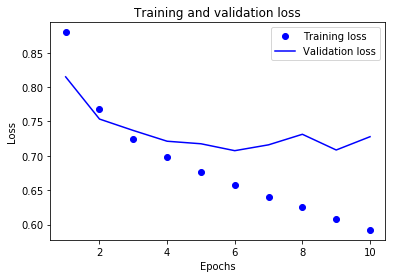

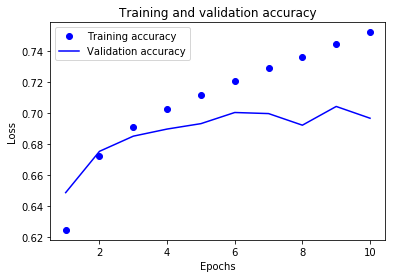

In [119]:
plt.clf()   # clear figure

loss8 = history8.history['loss']
val_loss8 = history8.history['val_loss']

epochs8 = range(1, len(loss8) + 1)

plt.plot(epochs8, loss8, 'bo', label='Training loss')
plt.plot(epochs8, val_loss8, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc8 = history8.history['acc']
val_acc8 = history8.history['val_acc']

plt.plot(epochs8, acc8, 'bo', label='Training accuracy')
plt.plot(epochs8, val_acc8, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test 5: Results
    
This test shows a more thorough run on the test 3 technique and because of this we were able to see a slight improvement in the results.
We hit a new top accuracy of 0.7043 which shows that this technique is much more thorough than previous but at a cost of time.
I would be interested at running this at an epoch of 20 to see how the result deviates and to see if more gain is acquired

Conclusion:

I was able to test a number of different techniques in improving the system. Some of the tests were more of an experiment to see how the system would change (Dropout attempt, Stacked LSTM).
If I was able to better understand the Dropout layer I would have liked to see how far I could have taken it as the attempt I made was quite basic.
The Stacked LSTM technique also quite a high result so that is another method which could be improved moreso by trying different epoch numbers and also by exploring different layer attributes.
The technique I went with and continued to explore was that which was used in Tests 3 and 5. This technique stood out to me as it made the most sense to me and also helped me clearly see the effect of increasing the depth of a train. Because of this I was able to reach an accuracy of 0.7043 which I believe to be fairly good. I'm sure there is room for improvement in that which I will try and research.